In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [41]:
df = pd.read_csv(
  "dateindex1.csv", 
  parse_dates=['datetime'], 
  index_col="datetime"
)

In [42]:
df.shape

(105191, 1)

In [44]:
df.head()

,G
datetime,
2005-01-01 00:00:00,0.0
2005-01-01 01:00:00,55.0
2005-01-01 02:00:00,41.0
2005-01-01 03:00:00,203.0
2005-01-01 04:00:00,421.0


In [45]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

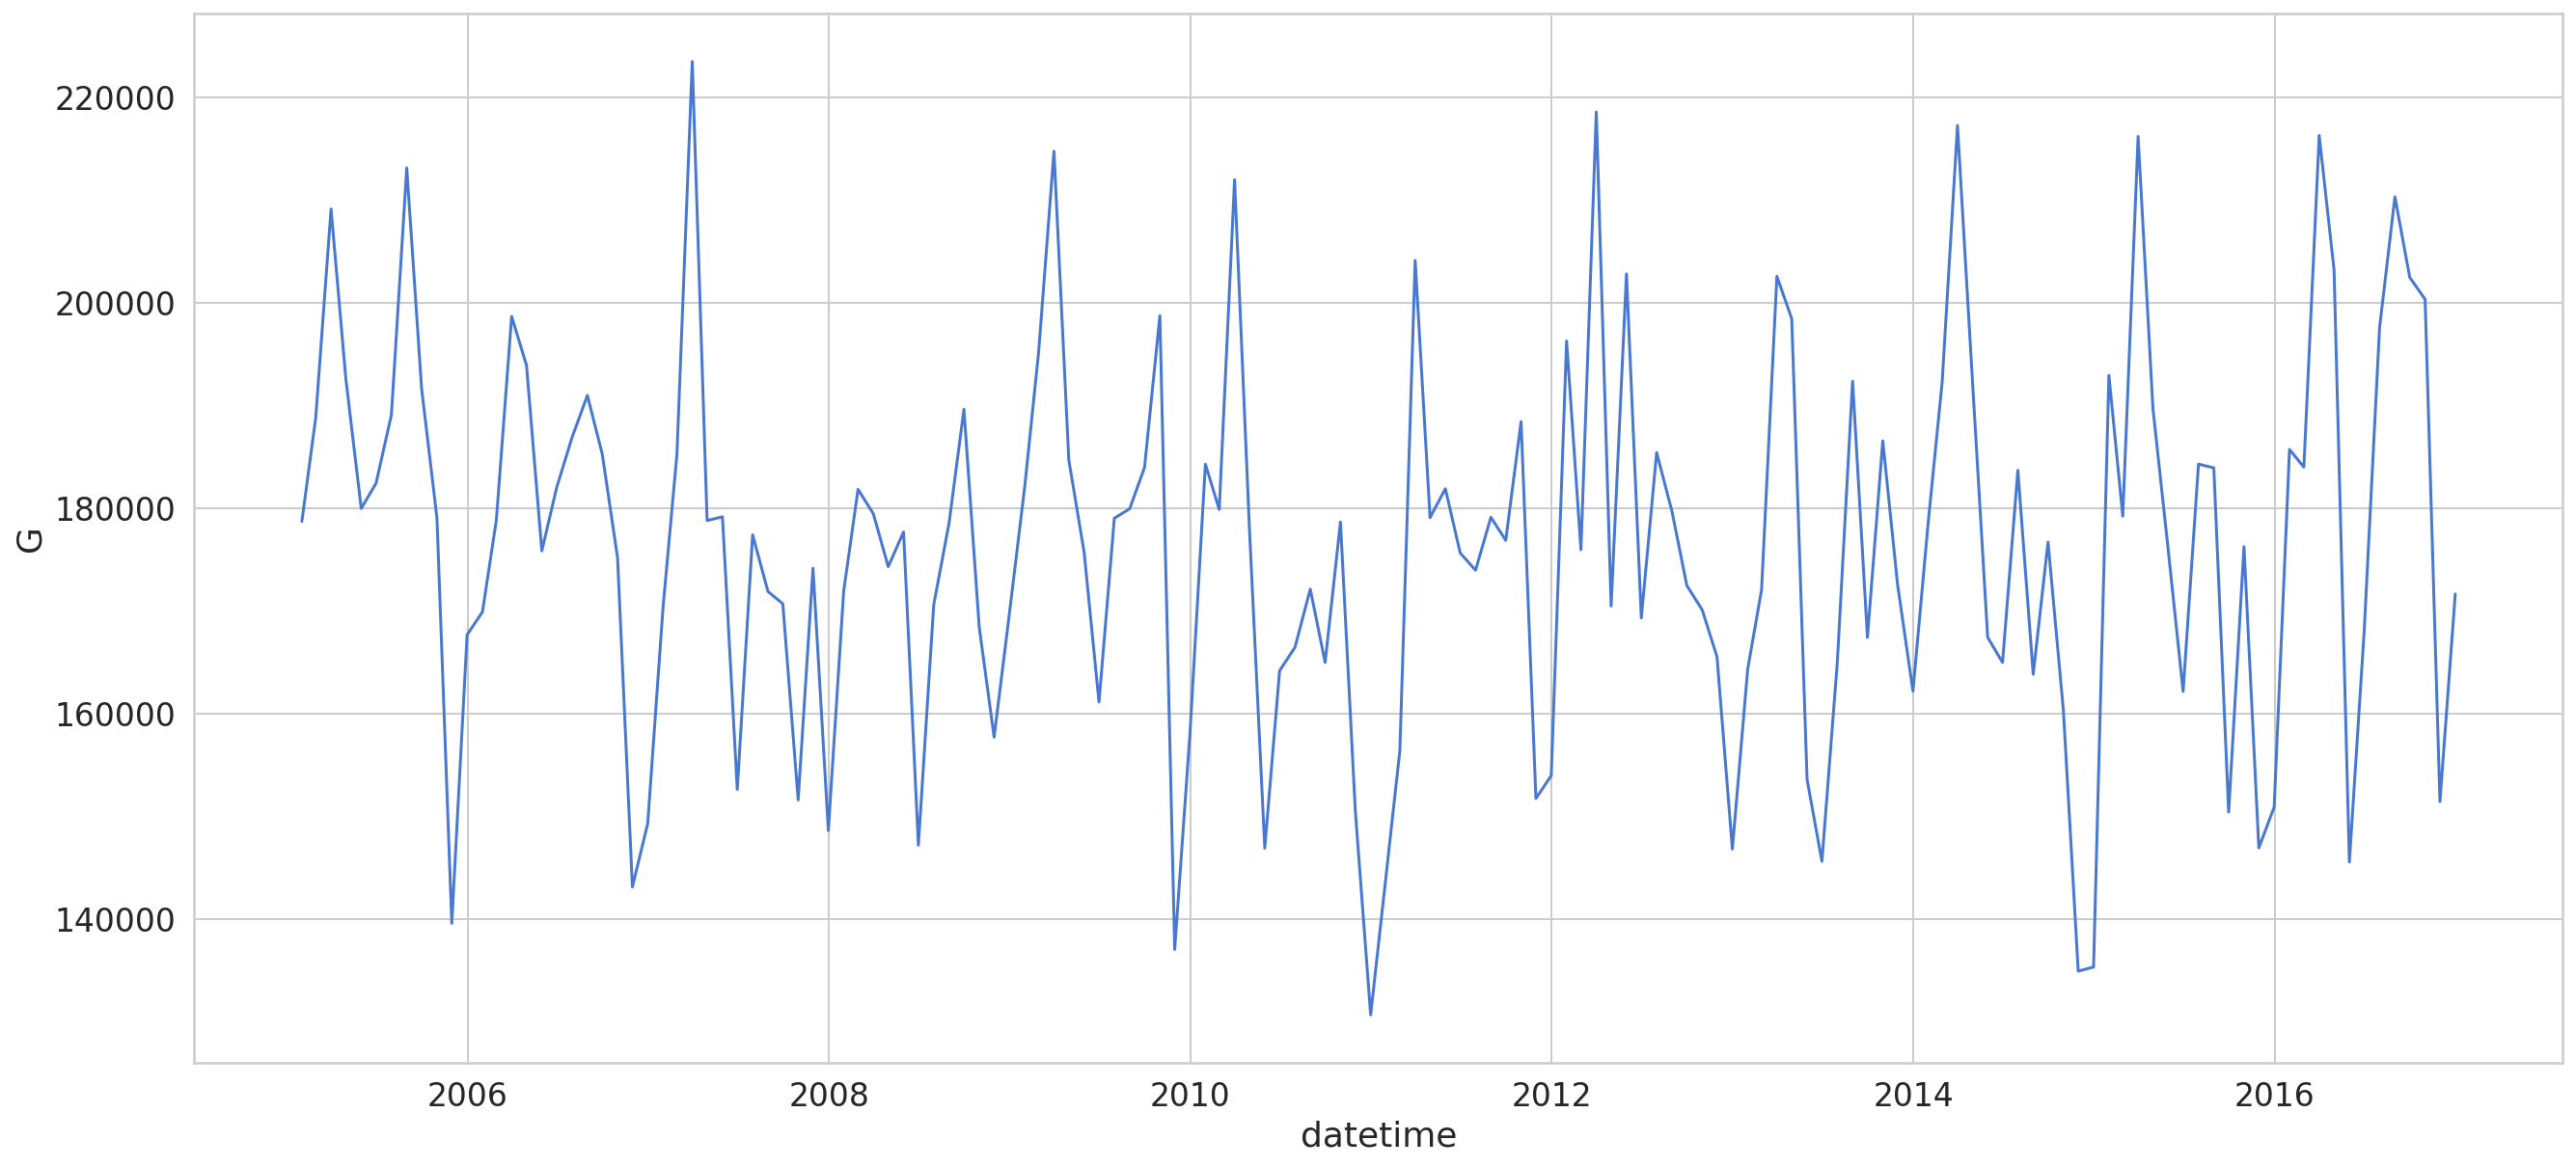

In [46]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="G", data=df_by_month);

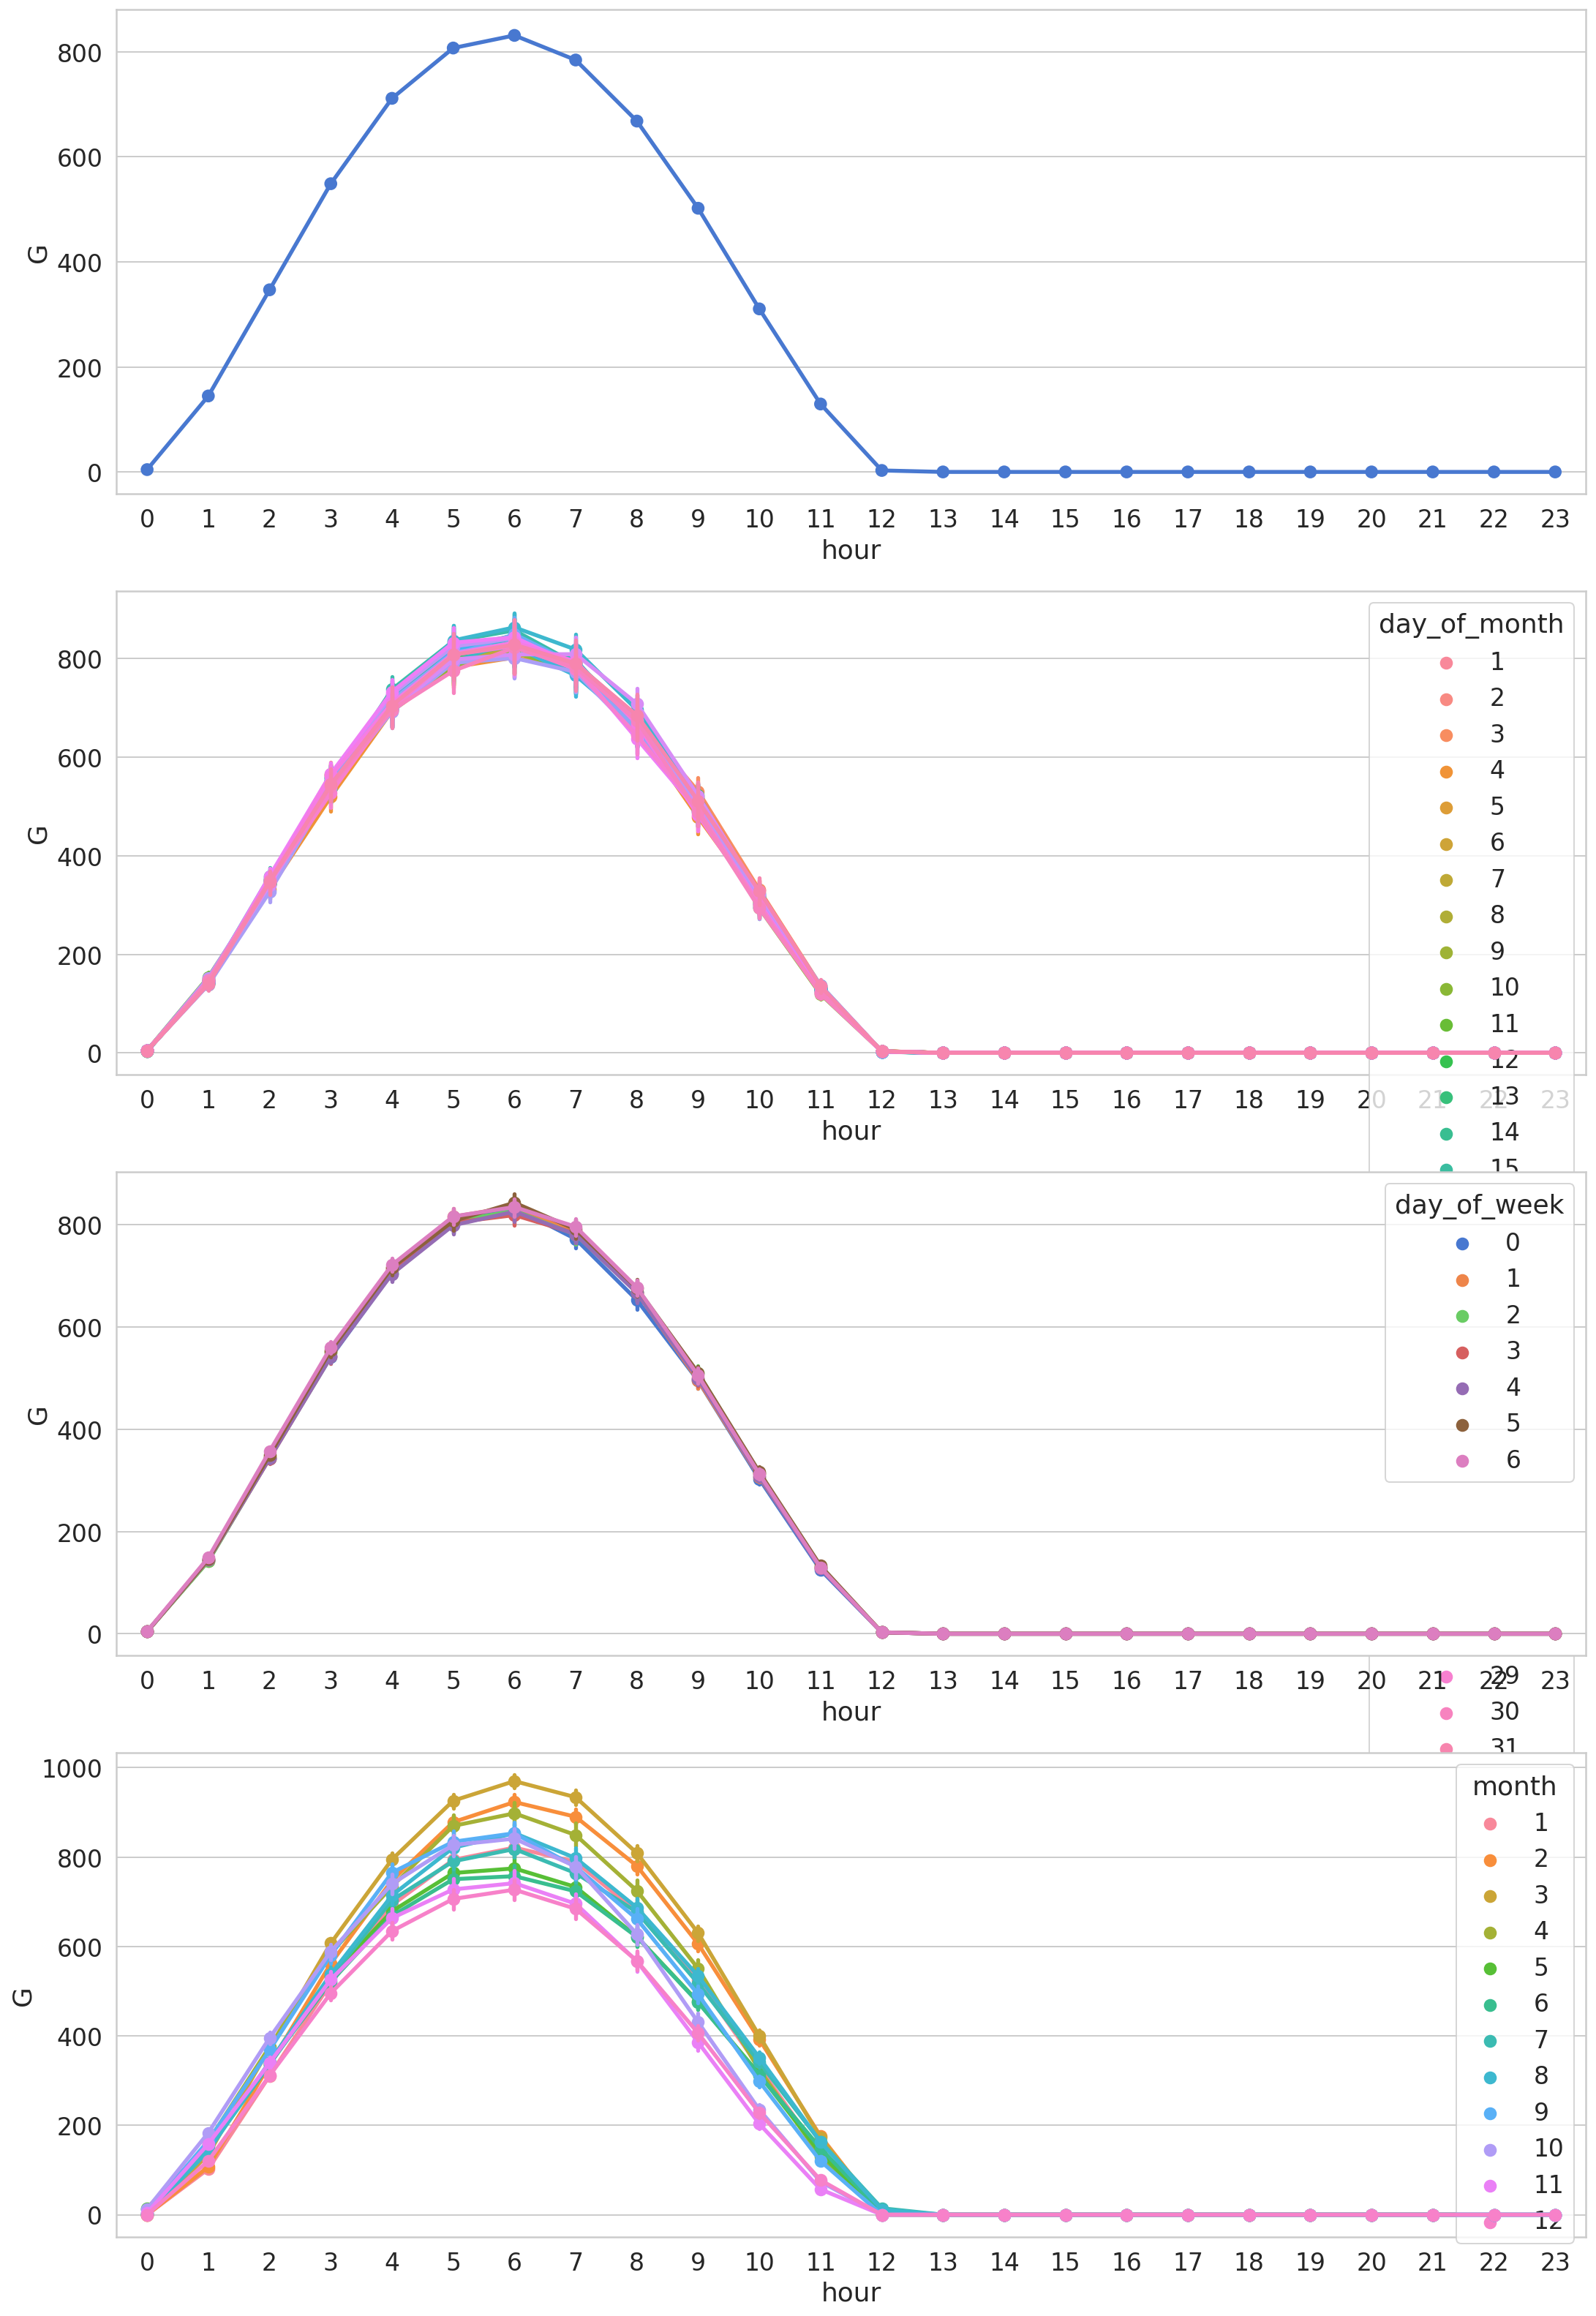

In [47]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='G', ax=ax1)
sns.pointplot(data=df, x='hour', y='G', hue='day_of_month', ax=ax2)
sns.pointplot(data=df, x='hour', y='G', hue='day_of_week', ax=ax3)
sns.pointplot(data=df, x='hour', y='G', hue='month', ax=ax4);

In [52]:
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

73633 31558


In [53]:
#preprocessing the data to maximize efficiency

from sklearn.preprocessing import RobustScaler

gi_transformer = RobustScaler() #G(i)

gi_transformer = gi_transformer.fit(train[['G']])

train['G'] = gi_transformer.transform(train[['G']])

test['G'] = gi_transformer.transform(test[['G']])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [54]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [55]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.G, time_steps)
X_test, y_test = create_dataset(test, test.G, time_steps)

print(X_train.shape, y_train.shape)

(73609, 24, 5) (73609,)


In [57]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [58]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
2071/2071 [==============================] - 90s 41ms/step - loss: 0.1245 - val_loss: 0.0333
Epoch 2/30
2071/2071 [==============================] - 81s 39ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 3/30
2071/2071 [==============================] - 80s 39ms/step - loss: 0.0285 - val_loss: 0.0316
Epoch 4/30
2071/2071 [==============================] - 81s 39ms/step - loss: 0.0273 - val_loss: 0.0311
Epoch 5/30
2071/2071 [==============================] - 79s 38ms/step - loss: 0.0265 - val_loss: 0.0312
Epoch 6/30
2071/2071 [==============================] - 79s 38ms/step - loss: 0.0260 - val_loss: 0.0311
Epoch 7/30
2071/2071 [==============================] - 78s 38ms/step - loss: 0.0258 - val_loss: 0.0302
Epoch 8/30
2071/2071 [==============================] - 76s 37ms/step - loss: 0.0254 - val_loss: 0.0302
Epoch 9/30
2071/2071 [==============================] - 79s 38ms/step - loss: 0.0250 - val_loss: 0.0305
Epoch 10/30
2071/2071 [==============================] - 79s 38m

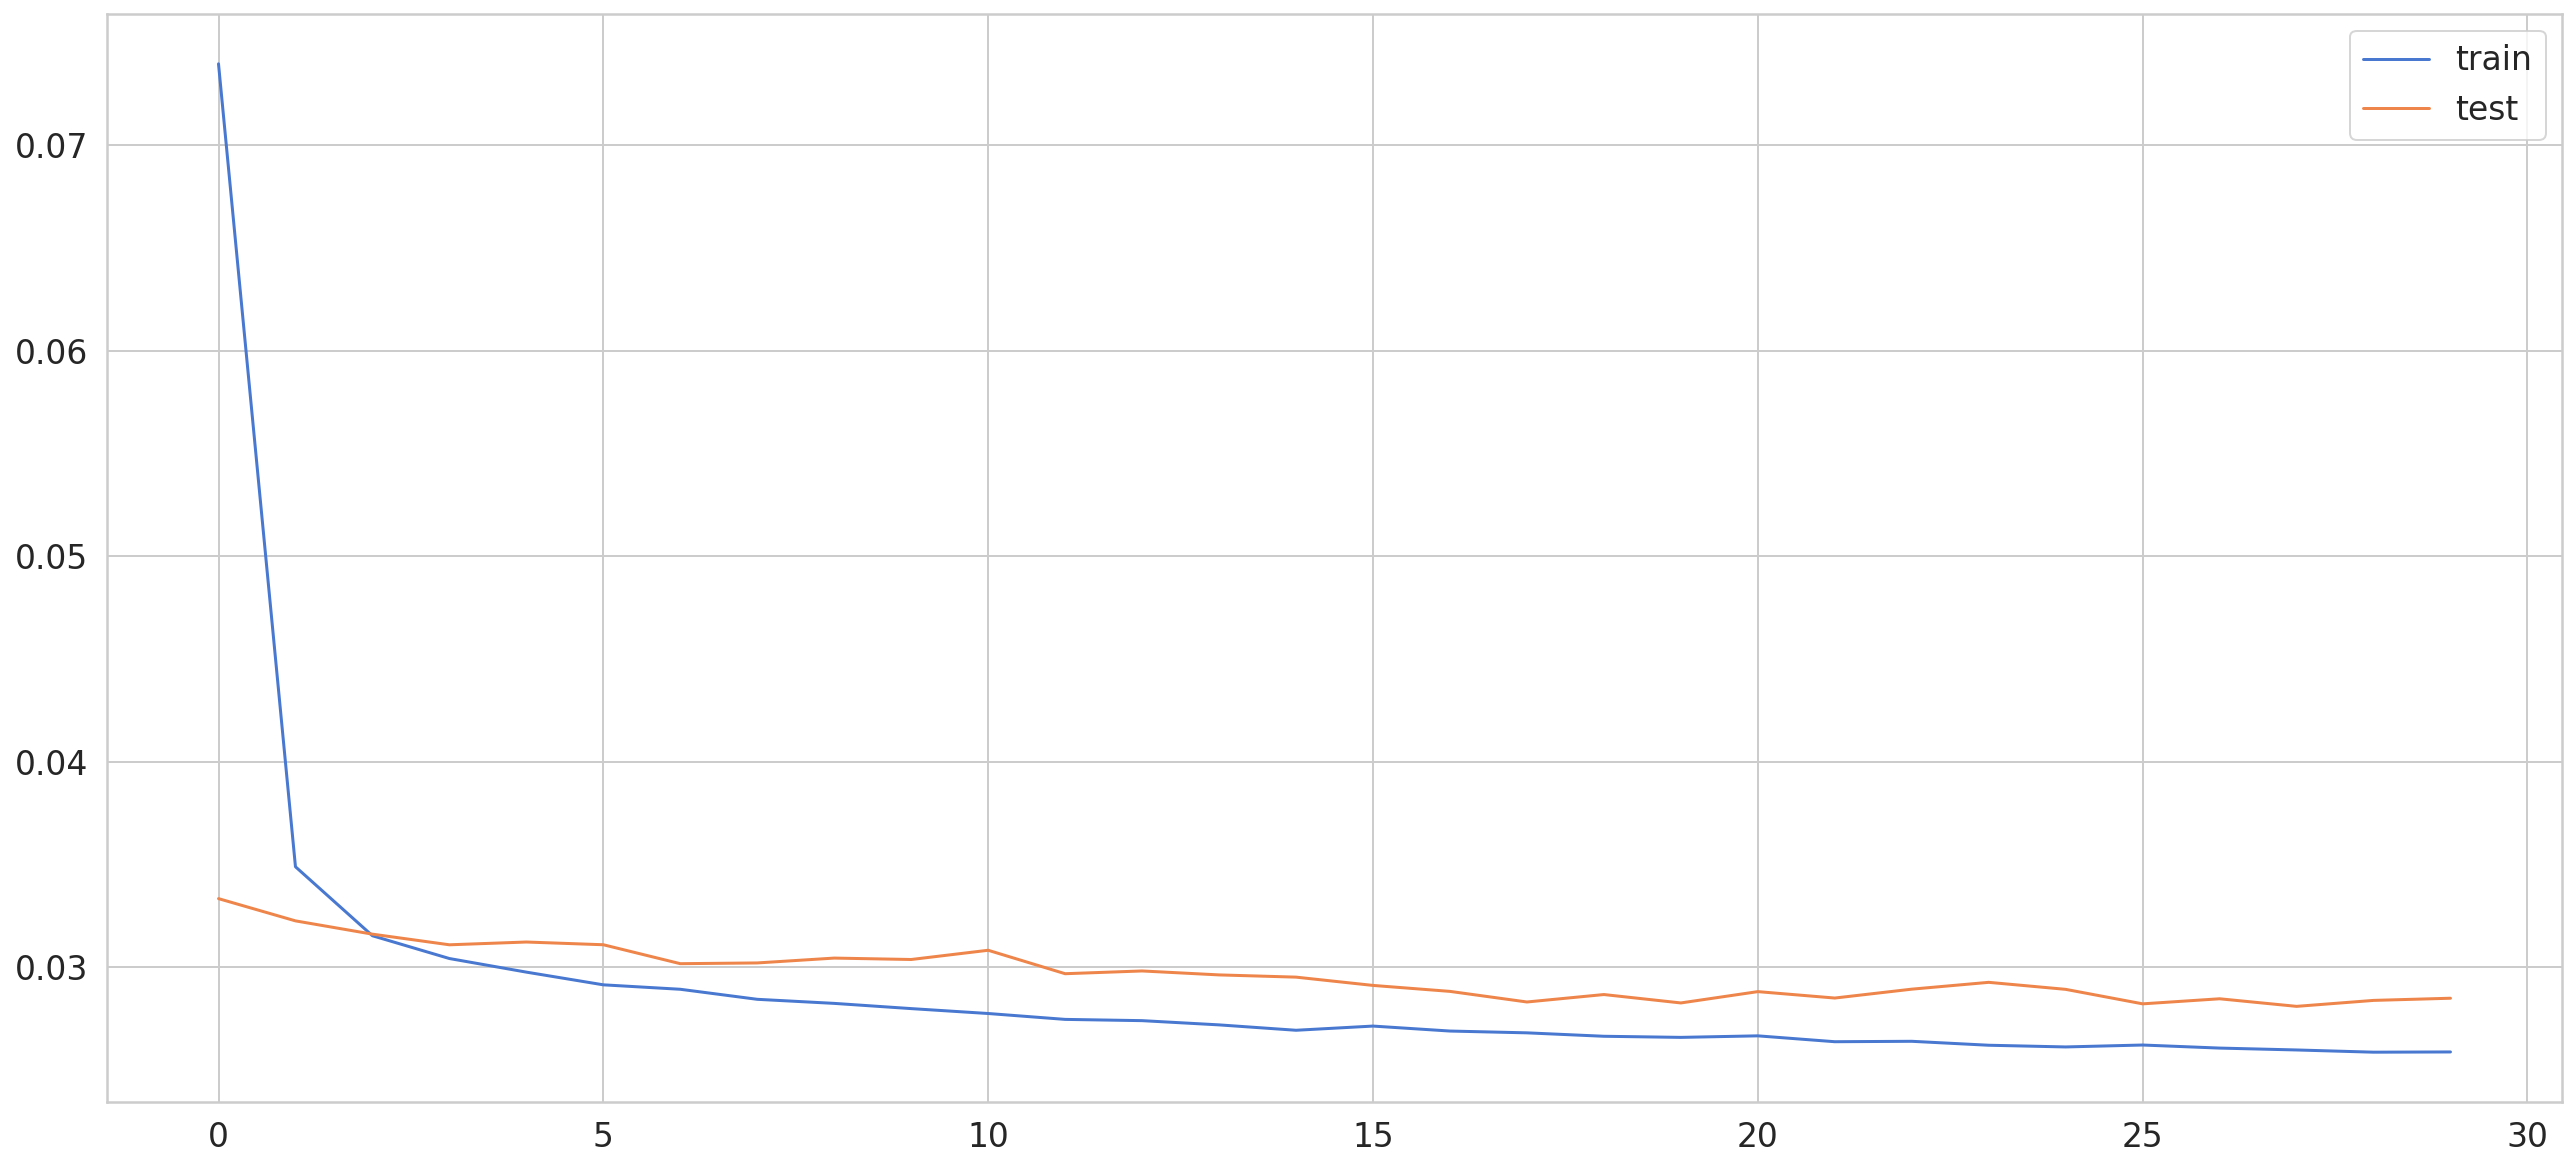

In [59]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [60]:
y_pred = model.predict(X_test)

In [62]:
y_train_inv = gi_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = gi_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = gi_transformer.inverse_transform(y_pred)

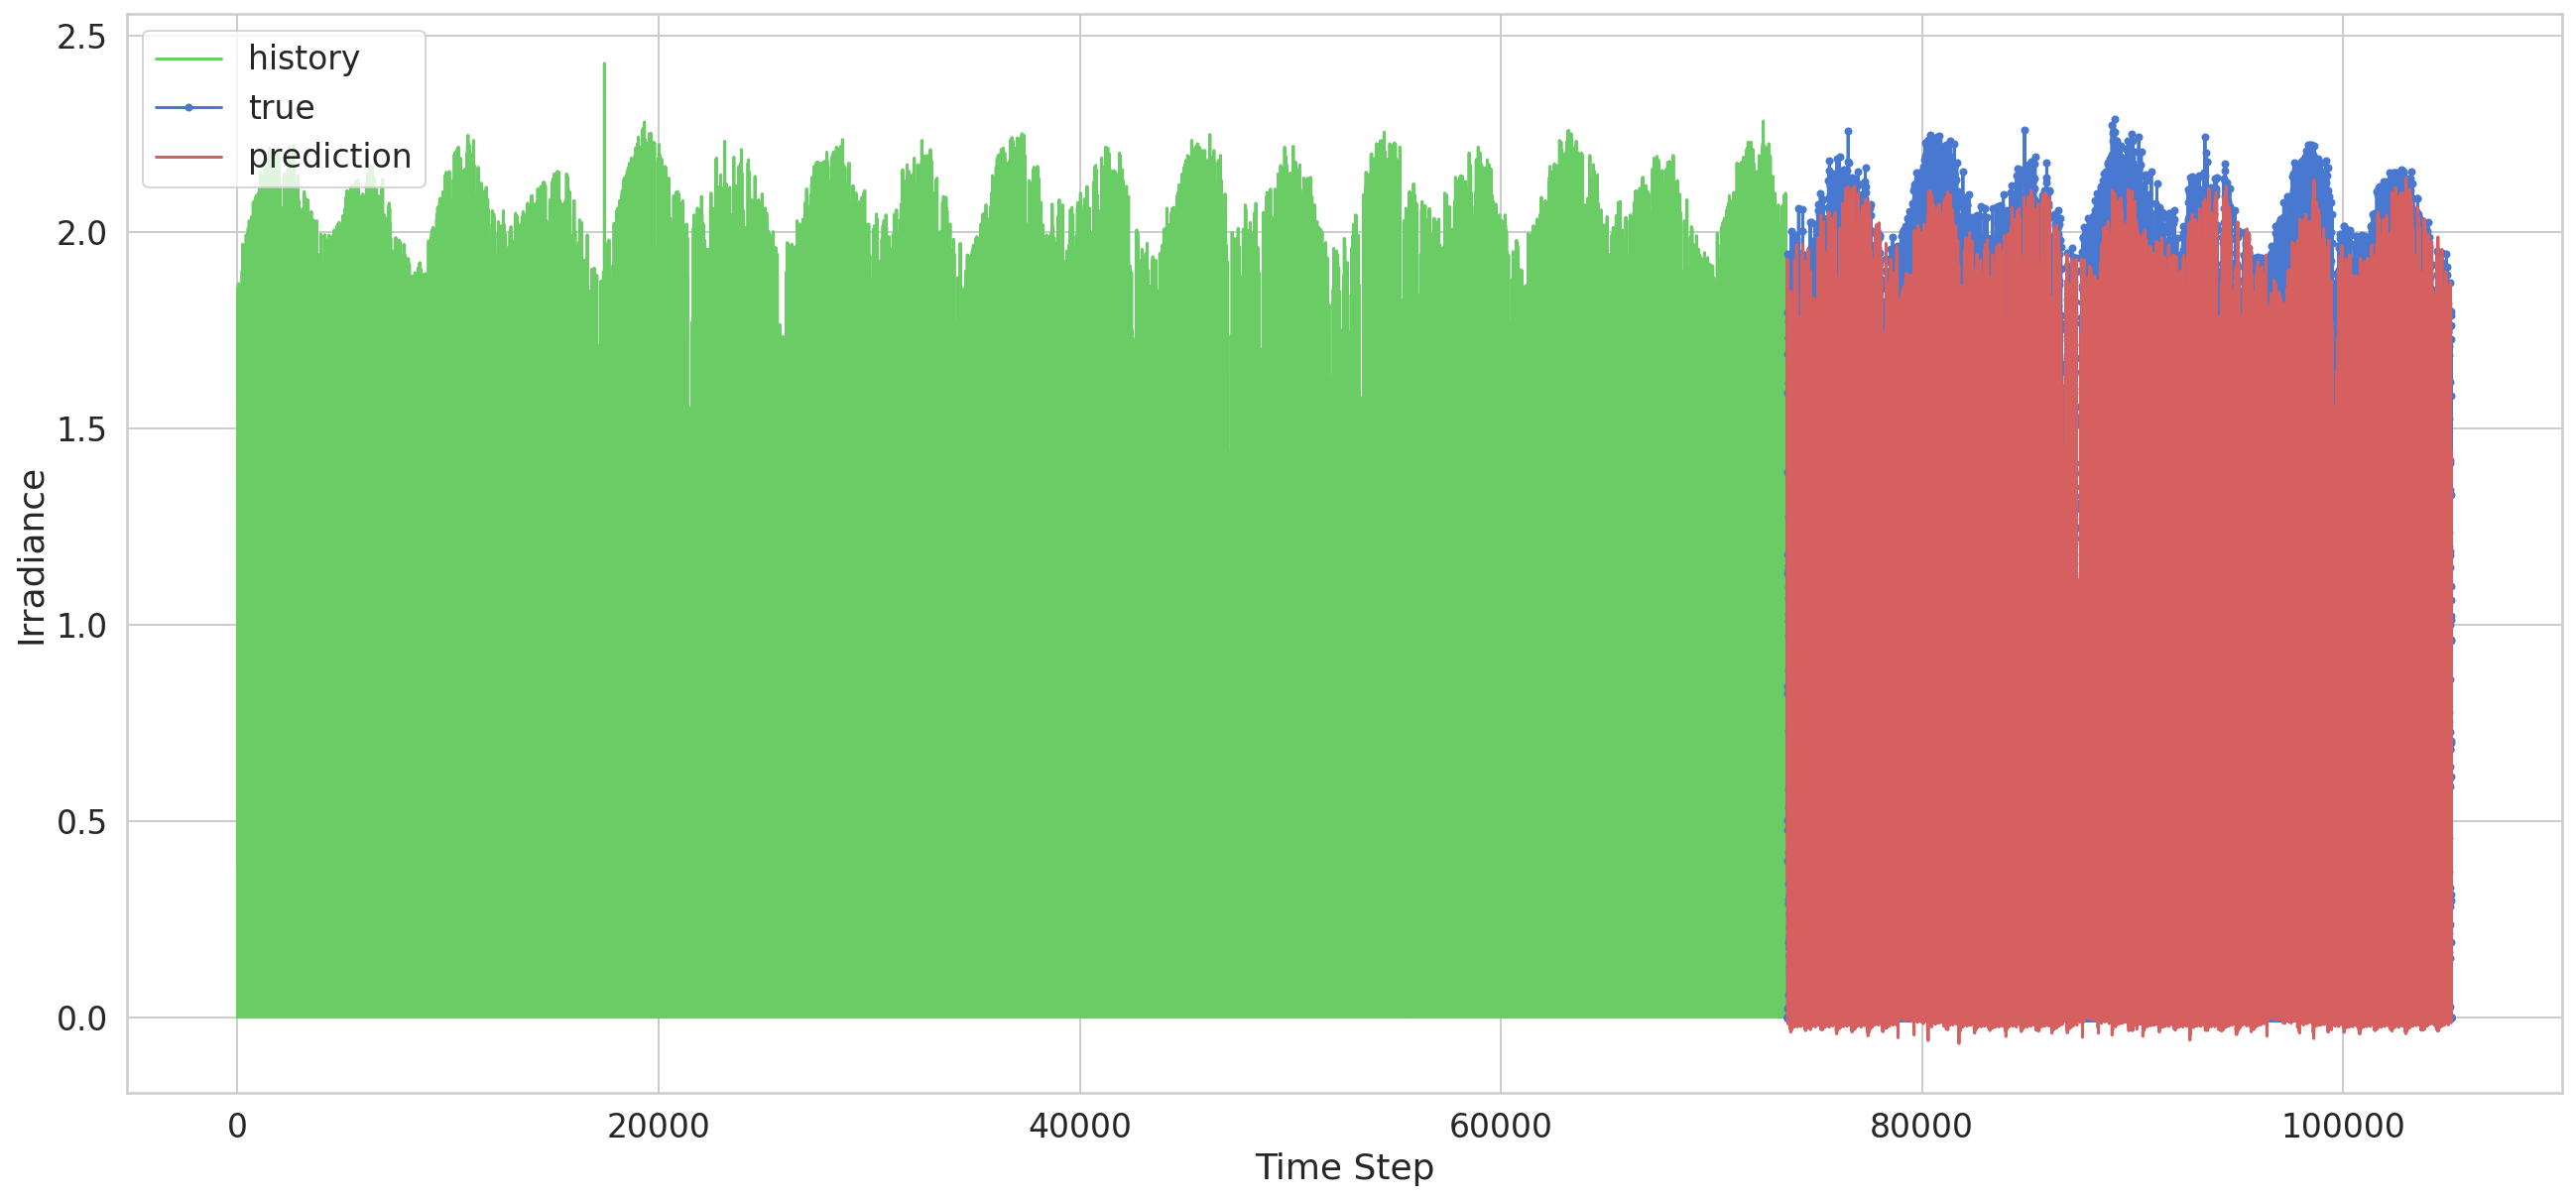

In [63]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Irradiance')
plt.xlabel('Time Step')
plt.legend()
plt.show();

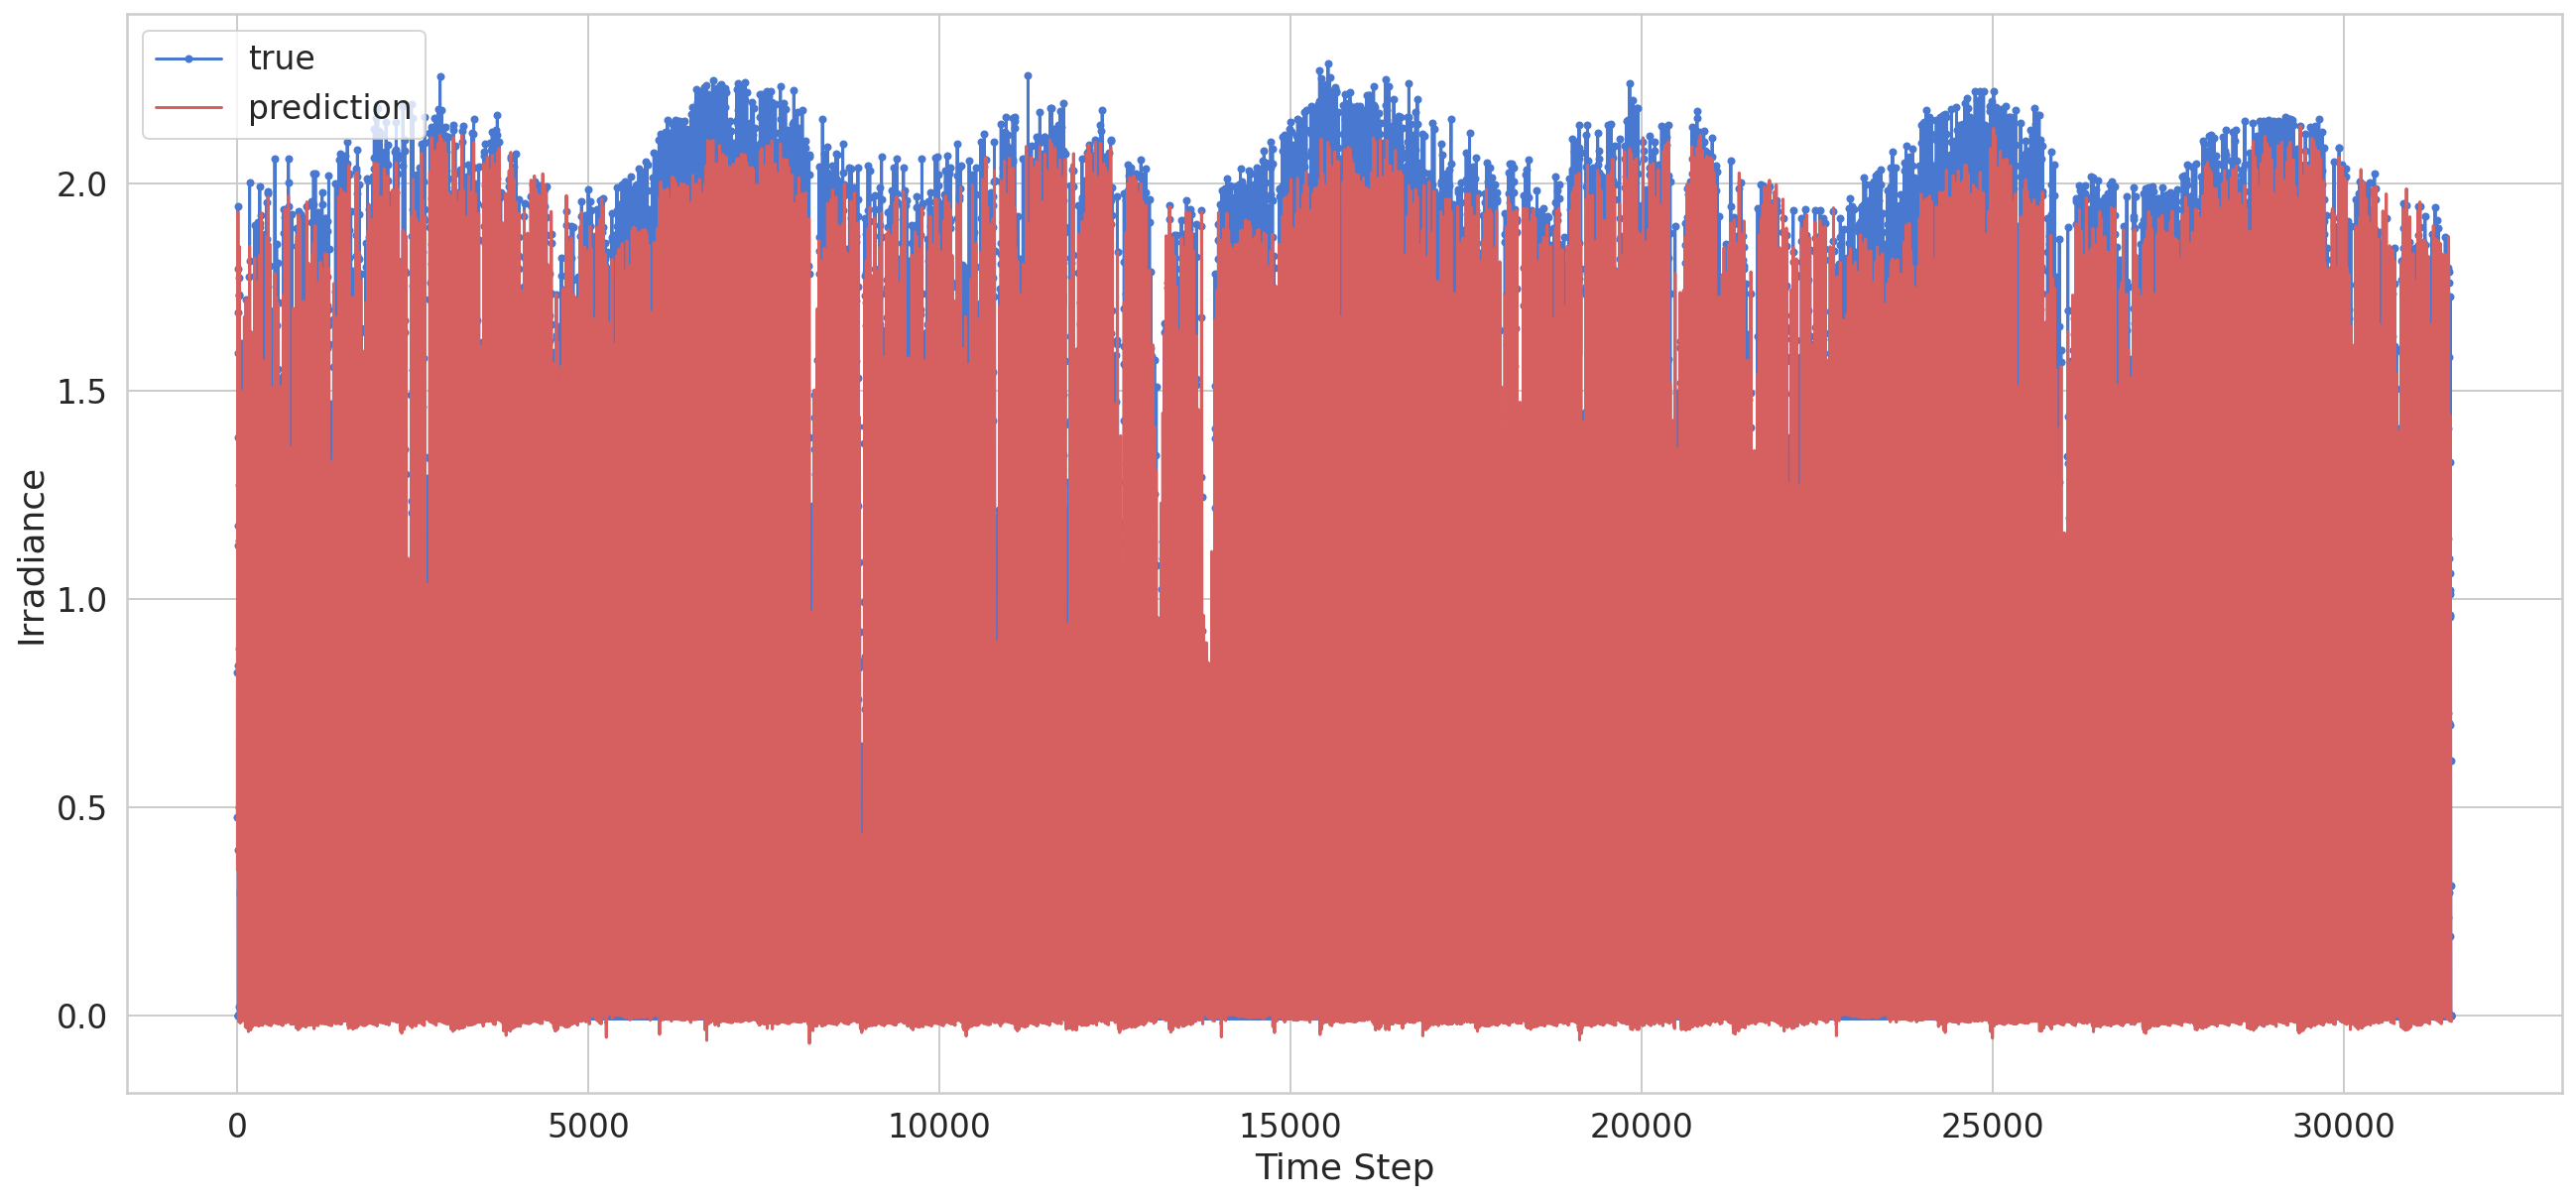

In [64]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Irradiance')
plt.xlabel('Time Step')
plt.legend()
plt.show();